In [16]:
import glob, os
import fnmatch
import sys
import astropy
import json
import parsnip

In [3]:
#read from .json file

for file in os.listdir("T202103221404394p014626/"):
    if file.endswith(".json"):
        f = open('T202103221404394p014626/'+file)
        data = json.load(f)
        id = data["ObjectID"]
        ra = data['RA-OBJECT']
        dec = data['DEC-OBJECT']
        print (id, ra, dec)

T202103221404394p014626 211.16428283 1.77410113


In [4]:
#read from pdf file

from tika import parser
for file in os.listdir("T202103221404394p014626/"):
    if file.endswith(".pdf"):
        pdf = parser.from_file('T202103221404394p014626/'+file)
        text = pdf['content']

2022-07-06 20:12:17,927 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to C:\Users\alina\AppData\Local\Temp\tika-server.jar.md5.
2022-07-06 20:12:20,227 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...


In [5]:
rs = ""
for i in range(len(text)):
    if text[i].startswith("T"):
        for j in range(i+36, i+43):
            rs += text[j]
        break
rs = float(rs)
print (rs)

0.22975


In [6]:
#construct a metadata table

from astropy.table import QTable, Table, Column
import numpy as np
metaTable = Table(names=('object_id', 'ra', 'dec', 'type', 'redshift'), dtype=('S2', 'i', 'i', 'S', 'f'))
metaTable.add_row((id, ra, dec, 'Unknown', rs))
print (metaTable)

       object_id         ra dec   type  redshift
----------------------- --- --- ------- --------
T202103221404394p014626 211   1 Unknown  0.22975


In [69]:
#read from .csv file

import csv
import lcdata

lightcurveTable = Table(names=('time(mjd)', 'flux', 'fluxerr', 'band'), dtype=('f', 'f', 'f', 'S'))

for file in os.listdir("T202103221404394p014626/"):
    if file.endswith(".csv"):
        csvFile = open('T202103221404394p014626/'+file)
        reader = csv.DictReader(csvFile)
        for row in reader:
            if row['alert'] == 'True':
                time = row['mjd']
                mag = float(row['mag'])
                magerr = float(row['magerr'])
                flux = 10**((22.5-mag)/2.5)
                fluxerr = 10**((22.5-mag)/2.5) - 10**((22.5-(mag+magerr))/2.5)
                band = 'des' + row['filter']
                lightcurveTable.add_row((time, flux, fluxerr, band))
print (lightcurveTable)

time(mjd)    flux      fluxerr   band
--------- ---------- ----------- ----
 59295.27  2.8618915  0.08899537 desg
59295.273   2.875543  0.07754689 desr
59295.273  1.9632537  0.15453683 desz
59297.227  2.6797485 0.113364875 desg
59297.227  2.3984513  0.08397903 desr
 59297.23  1.6680049  0.16853811 desz
59301.188  3.3626912  0.29650298 desr
59301.188  2.3671358  0.25516427 desz
59307.336  3.0541835   0.2614075 desg
 59310.19   2.031543 0.097065225 desg
      ...        ...         ...  ...
 59319.17  1.3874642  0.06880906 desg
59319.176  1.9609144  0.07222642 desr
59319.176  1.4081056  0.15810855 desz
59319.305  1.3832716  0.07386642 desg
59322.176  1.5523274  0.07642046 desr
59322.176  1.3023627  0.15798043 desz
  59322.3  1.1492501   0.0891355 desg
 59340.15  1.1042311  0.09063203 desr
59343.152 0.98615205  0.12685703 desr
59346.156  1.1942683  0.10794016 desr
59352.082 0.78507364  0.08041653 desr
Length = 30 rows


In [75]:
#combine the two tables into lcdata

light_curve = Table({
     'time': list(lightcurveTable['time(mjd)']),
     'flux': list(lightcurveTable['flux']),
     'fluxerr': list(lightcurveTable['fluxerr']),
     'band': list(lightcurveTable['band']),})

print(light_curve, '\n')

light_curve.meta = {
    'object_id': id,
    'ra': ra,
    'dec': dec,
    'type': "Unknown",
    'redshift': rs}

print(light_curve.meta)

   time      flux      fluxerr   band
--------- ---------- ----------- ----
 59295.27  2.8618915  0.08899537 desg
59295.273   2.875543  0.07754689 desr
59295.273  1.9632537  0.15453683 desz
59297.227  2.6797485 0.113364875 desg
59297.227  2.3984513  0.08397903 desr
 59297.23  1.6680049  0.16853811 desz
59301.188  3.3626912  0.29650298 desr
59301.188  2.3671358  0.25516427 desz
59307.336  3.0541835   0.2614075 desg
 59310.19   2.031543 0.097065225 desg
      ...        ...         ...  ...
 59319.17  1.3874642  0.06880906 desg
59319.176  1.9609144  0.07222642 desr
59319.176  1.4081056  0.15810855 desz
59319.305  1.3832716  0.07386642 desg
59322.176  1.5523274  0.07642046 desr
59322.176  1.3023627  0.15798043 desz
  59322.3  1.1492501   0.0891355 desg
 59340.15  1.1042311  0.09063203 desr
59343.152 0.98615205  0.12685703 desr
59346.156  1.1942683  0.10794016 desr
59352.082 0.78507364  0.08041653 desr
Length = 30 rows 

{'object_id': 'T202103221404394p014626', 'ra': 211.16428283, 'dec': 1

In [71]:
print (dataset.light_curves)

[<Table length=30>
      time         flux      fluxerr    band
    float64      float32     float32   bytes4
 -------------- ---------- ----------- ------
 59295.26953125  2.8618915  0.08899537   desg
  59295.2734375   2.875543  0.07754689   desr
  59295.2734375  1.9632537  0.15453683   desz
  59297.2265625  2.6797485 0.113364875   desg
  59297.2265625  2.3984513  0.08397903   desr
 59297.23046875  1.6680049  0.16853811   desz
     59301.1875  3.3626912  0.29650298   desr
     59301.1875  2.3671358  0.25516427   desz
  59307.3359375  3.0541835   0.2614075   desg
 59310.19140625   2.031543 0.097065225   desg
            ...        ...         ...    ...
 59319.17578125  1.9609144  0.07222642   desr
 59319.17578125  1.4081056  0.15810855   desz
  59319.3046875  1.3832716  0.07386642   desg
 59322.17578125  1.5523274  0.07642046   desr
 59322.17578125  1.3023627  0.15798043   desz
 59322.30078125  1.1492501   0.0891355   desg
  59340.1484375  1.1042311  0.09063203   desr
 59343.15234375 

In [72]:
print(dataset.meta)

       object_id             ra         dec       type  redshift
----------------------- ------------ ---------- ------- --------
T202103221404394p014626 211.16428283 1.77410113 Unknown  0.22975


In [83]:
#save the dataset into .h5 file and read from that file (to test if we still get the same error)

dataset = lcdata.from_light_curves([light_curve])
dataset.write_hdf5('./dataset.h5')

dataset = parsnip.load_dataset('./dataset.h5')

Unknown dataset type 'dataset.h5'. Using default parsing. Specify how to parse it in instruments.py if necessary.


In [84]:
#make prediction with the built-in plasticc model (model1)

model1 = parsnip.load_model('plasticc')
model1.predict(light_curve)

Preprocessing dataset: 0it [00:00, ?it/s]


ValueError: no values provided to stack.

In [74]:
#make plots with model1

parsnip.plot_light_curve(light_curve, model1)
parsnip.plot_spectrum(light_curve, model1, time=53000.)

ValueError: Light curve has no usable observations! Valid bands are ['lsstu', 'lsstg', 'lsstr', 'lssti', 'lsstz', 'lssty'].

In [53]:
#make prediction with the built-in ps1 model (model2)
#this cell was run before meeting 7/6, when I changed the band names into "ps1::", so it produced outcomes without error

model2 = parsnip.load_model('ps1')
model2.predict(light_curve)

{'object_id': 'T202103221404394p014626',
 'ra': 211.16428283,
 'dec': 1.77410113,
 'type': 'Unknown',
 'redshift': 0.22975,
 'parsnip_reference_time': 59310.20035515625,
 'parsnip_scale': 3.3626912,
 'reference_time': 59303.248528107,
 'reference_time_error': 0.44368592,
 'color': -0.14553168,
 'color_error': 0.018239824,
 'amplitude': 0.06140082,
 'amplitude_error': 0.00058427313,
 's1': -1.1706808,
 's1_error': 0.3277503,
 's2': 0.24408299,
 's2_error': 0.72915846,
 's3': 0.3581882,
 's3_error': 0.09860494,
 'total_s2n': 113.70687,
 'count': 30,
 'count_s2n_3': 30,
 'count_s2n_5': 30,
 'count_s2n_3_pre': 0,
 'count_s2n_3_rise': 8,
 'count_s2n_3_fall': 22,
 'count_s2n_3_post': 0,
 'model_chisq': 250.60995,
 'model_dof': 24,
 'luminosity': -12.334563157684705,
 'luminosity_error': 0.010331887}

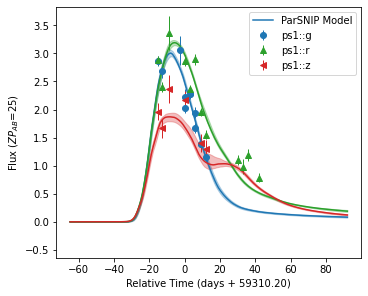

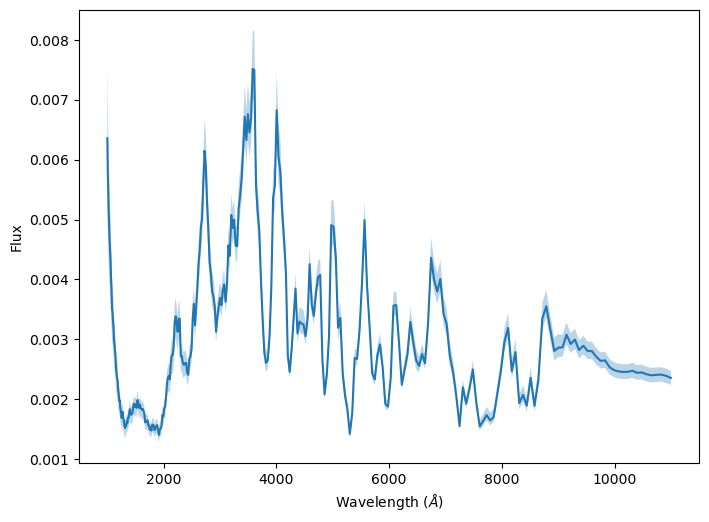

In [54]:
#make plots with model2

parsnip.plot_light_curve(light_curve, model2)
parsnip.plot_spectrum(light_curve, model2, time=53000.)

In [66]:
#classifying lightcurves (with band names changed so there are no errors here)

prediction1 = model1.predict_dataset(dataset)
print(prediction1)

       object_id             ra      ...      luminosity     luminosity_error
----------------------- ------------ ... ------------------- ----------------
T202103221404394p014626 211.16428283 ... -11.288948915130995     0.0103245415


In [67]:
#Encountering errors here (7/6/2022)

classifier = parsnip.Classifier()
classifier.train(prediction1)

Training classifier with keys:
    color
    color_error
    s1
    s1_error
    s2
    s2_error
    s3
    s3_error
    luminosity
    luminosity_error
    reference_time_error


KeyError: 'original_object_id'